# FaceNet-PyTorch


**References**
- DeepLearning (2020) Simple face recognition project with facenet pytorch https://www.youtube.com/watch?v=JXHwFy12RkY&ab_channel=DeepLearning

In [1]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''<style> pre { white-space: pre-wrap; }</style>'''))
get_ipython().events.register('pre_run_cell', set_css)

## Get data

Dataset from: 
  https://github.com/biplob004/pytorch_face_recognition

In [3]:
!git clone https://github.com/biplob004/pytorch_face_recognition

Cloning into 'pytorch_face_recognition'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 26 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [5]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9 MB 4.0 MB/s 


In [13]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torchvision import datasets
from torch.utils.data import DataLoader

import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

In [2]:
mtcnn = MTCNN(image_size=240, margin=0, min_face_size=20)
# pre-trained vggface2 model on evaluation mode
resnet = InceptionResnetV1(pretrained='vggface2').eval()


dataset = datasets.ImageFolder('/content/pytorch_face_recognition/photos/')
idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}

def collate_fn(x):
    return x[0]

loader = DataLoader(dataset, collate_fn=collate_fn)

faces = []
names = []
embeddings = []

for img, idx in loader:
    # prob - the probability od detected faces
    face, prob = mtcnn(img, return_prob=True)
    if face is not None and prob > 0.9:
        emb = resnet(face.unsqueeze(0))      # convert the image into tensor
        embeddings.append(emb.detach())  
        names.append(idx_to_class[idx])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [3]:
data = [embeddings, names]
torch.save(data, 'data.pt')

In [10]:
def face_match(img_path, data_path):
    img = Image.open(img_path)                    
    face, prob = mtcnn(img, return_prob=True)     
    emb_pred = resnet(face.unsqueeze(0)).detach()

    saved_data = torch.load('data.pt')
    embedding_list = saved_data[0]
    name_list = saved_data[1]
    dist_list = []

    for idx, embedding in enumerate(embedding_list):
        # Compare prediction with correct label 
        dist = torch.dist(emb_pred, embedding).item()
        dist_list.append(dist)
    
    idx_min = dist_list.index(min(dist_list))

    return name_list[idx_min]

Identity matched with:  angelina_jolie


Identity matched with:  angelina_jolie


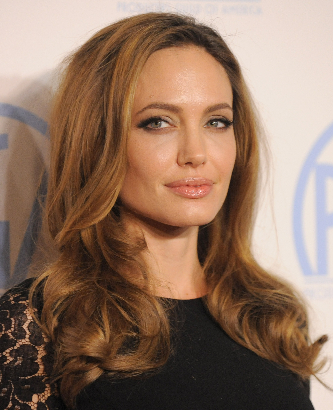

In [16]:
path = "/content/pytorch_face_recognition/1.jpg"
test_img = cv2.imread(path)
test_img = cv2.resize(test_img, (0,0), fx=0.20, fy=0.20)

person = face_match(path, 'data.pt')      # predict the face match.
print('Identity matched with: ', person)
cv2_imshow(test_img)